# Building a Machine Learning Model to Categorize Customers Sentiments of a Restaurant in New York City, USA

### Project Objective:
    The first  phase of this project involved  scraping unstructured customer reviews data from Yelp business listings into a structured csv format.
    This second phase protrays the use of Natural Laguage TooKit(nltk) for cleaning and pre-pocessing the data and doing feature engineering work to prepare it for building a machine learning model. I also looked into  the selection of the best algorithm for the model based on prediction accuracy.

### Summary of Results:
    We use Naive Bayes, Benouli Naive Bayes, Multinomial Naive Bayes, Support Vector Classifier(SVC),Stochastic Gradient Descent (SGD), RandomForest and logistic regression Classifiers to build our model. Of all the algorithms used,logistic regression performed better with over 91% accuracy.

In [1]:
from wordcloud import WordCloud
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
% matplotlib inline
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
# we read the csv data as a Pandas df and inspect it
katz = pd.read_csv('katz.csv')
katz.head()

,date,location,rating,review
0,9/18/2020,"Reno, NV",5 star rating,Katz's does delivery! Nationwide!
1,8/16/2020,"Los Angeles, CA",5 star rating,My phone says it's been 4 years since I enjoye...
2,9/2/2020,"West Milford, NJ",5 star rating,There's not much to say that hasn't been said ...
3,9/20/2020,"Manhattan, NY",5 star rating,I woke up craving a Reuben and no other deli w...
4,9/21/2020,"Laveen Village, Laveen Village, AZ",4 star rating,"Latkas are great, pickles kind of taste like m..."


In [3]:
# removing stings from rating and converting to integer
katz['rating'] = katz['rating'].str.split().str[0].astype(int)

In [4]:
katz['rating'].value_counts()

5    3474
4    2328
3    1038
2     534
1     473
Name: rating, dtype: int64

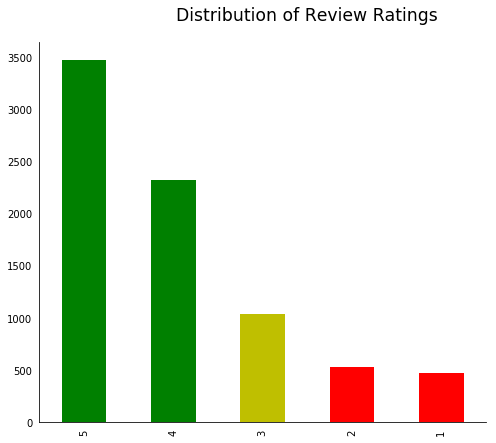

In [5]:
ax = katz['rating'].value_counts().plot(kind="bar", figsize = (8,7), color ="ggyrr")
ax.tick_params(bottom=False, top=False, left=False, right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Distribution of Review Ratings", fontsize="xx-large").set_position([0.6, 1.04])
plt.show()

    It is obvious that we have more 4 and 5 stars ratings than lower ones.
    we will now create a second column to label the ratings as positive, neutral and negative.

In [6]:
# writing a function to label each review
def labels(row):
    if row >=4:
        return 'positive'
    elif row == 3:
        return 'neutral'
    else:
        return 'negative'

In [7]:
# applying the label to each rows in the df and writing them in a new colum named label
katz['label'] = katz['rating'].apply(labels)

    we now slice out the positive and negative dataframe. We'll leave the neutral because we won't need it as it make create noise in our model and make it less accurate

In [8]:
pos = katz.loc[katz['label']=='positive']
neg = katz.loc[katz['label']=='negative']

In [9]:
pos.head()

,date,location,rating,review,label
0,9/18/2020,"Reno, NV",5,Katz's does delivery! Nationwide!,positive
1,8/16/2020,"Los Angeles, CA",5,My phone says it's been 4 years since I enjoye...,positive
2,9/2/2020,"West Milford, NJ",5,There's not much to say that hasn't been said ...,positive
3,9/20/2020,"Manhattan, NY",5,I woke up craving a Reuben and no other deli w...,positive
4,9/21/2020,"Laveen Village, Laveen Village, AZ",4,"Latkas are great, pickles kind of taste like m...",positive


In [10]:
neg.head()

,date,location,rating,review,label
12,8/11/2020,"Franklin Square, NY",1,"Sunday, August 9, 2020 was excited to drive in...",negative
26,6/13/2020,"Brooklyn, NY",1,"Overpriced, overhyped, and not worth the trek.",negative
38,8/15/2020,"East Village, Manhattan, NY",1,"I was physically assaulted by the staff, I gav...",negative
80,12/24/2019,"Santa Rosa, CA",1,There's a reason this place is famous and fabu...,negative
125,6/15/2020,"San Diego, CA",2,Katz's Pastrami used to be great.. but now has...,negative


    We clean the review columns by removing unneccassary strings and tokenize the reviews of positive and negative dataframes

In [11]:
pos['review'] = pos['review'].str.replace(r'([^(a-zA-Z)\s])|\xa0','').astype(str)
neg['review'] = neg['review'].str.replace(r'([^(a-zA-Z)\s])|\xa0','').astype(str)

C:\Users\Ikeen\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Ikeen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
# the word_tokenize function helps us to split strings into words
tokenized_pos = pos['review'].apply(word_tokenize)
tokenized_neg = neg['review'].apply(word_tokenize)


In [13]:
# generating positive words tokens in a list
token_pos = []
for row in tokenized_pos:
    token_pos.extend(row)
token_pos[:10]

['Katzs',
 'does',
 'delivery',
 'Nationwide',
 'My',
 'phone',
 'says',
 'its',
 'been',
 'years']

In [14]:
# generating negative words token in a list
token_neg = []
for row in tokenized_neg:
    token_neg.extend(row)
token_neg[:10]

['Sunday',
 'August',
 'was',
 'excited',
 'to',
 'drive',
 'in',
 'from',
 'Long',
 'Island']

### OBSERVATION: 
    the tokens have some words that we don't need. 
    we will now write a funtion to :
    
    1. remove stop_words. stop_words are words the aren't important for knowing the sentiment behind a text.
    2. change multiple words of the same form into their base words e.g beginning and begins to begin.

In [15]:
# this list shows some words known has stop words. They are words that have no particular sentiments attached to them.
# we remove this types of words from our word tokens
stop_words = list(set(stopwords.words('english')))
stop_words[:10]

["you're",
 'myself',
 'should',
 'shan',
 "don't",
 'from',
 't',
 'aren',
 'had',
 "couldn't"]

In [16]:
# nltk lemmatizer is used to take words to their base words
lemmatizer = WordNetLemmatizer()

In [17]:
def add_to_bow(tokens):
    global clean
    """
    the funtion takes in a list of words and a list. The function returns words that are abjectives after removing stop_words
    and saves it in the list.
    arg('str'): a list of strings of our tokenized words.
    returns(list): a list of words
    """
    stop_words = list(set(stopwords.words('english')))
#     picking words in tokens that are not stop_words and converting to their base words where neccessary.
    cleaned = [(lemmatizer.lemmatize(w)).lower() for w in tokens if not w.lower() in stop_words]
    return cleaned

In [18]:
pos_bows = add_to_bow(token_pos)
pos_bows[:10]

['katzs',
 'delivery',
 'nationwide',
 'phone',
 'say',
 'year',
 'since',
 'enjoyed',
 'one',
 '(']

In [19]:
neg_bows =  add_to_bow(token_neg)
neg_bows[:10]

['sunday',
 'august',
 'excited',
 'drive',
 'long',
 'island',
 'get',
 'city',
 'first',
 'time']

    some words are likely to appear more in our tokens that other words. We are more interested in words with higher frequenc-ies, so we create a frequency ditribution to pick the most frequently used words. For both positive and negative cases, we will pick the top 600 words for two reasons:
    1. it will make our code processing faster and 
    2. it makes our word_cloud visualization and model training less bias.

In [20]:
ps = nltk.FreqDist(pos_bows)
# we pick the 600 most used words and rewrite it into the old_list
pos_bows = [i[0] for i in sorted(ps.items(), key=lambda x: x[1], reverse=True)][:600]

In [21]:
ng = nltk.FreqDist(neg_bows)
neg_bows = [i[0] for i in sorted(ng.items(), key=lambda x: x[1], reverse=True)][:600]

In [22]:
def wordcloud_draw(data,color ='black', title="title"):
    """
    this function takes in our tokens, joins them together to form a word_cloud
    which helps us to visualize the most used positive and negative words in the reviews.
    arg(list and strings): data refers to  the list of tokenized words.
    """
    text = ' '.join(data)
    wordcloud = WordCloud(background_color= color, width=3000, height=2000).generate(text)

    plt.figure(1, figsize = (15, 9))
    # Display the generated image:
    plt.imshow(wordcloud, interpolation= "bilinear")
    plt.title(title, fontsize="xx-large").set_position([0.5, 1.05])
    plt.axis("off")
    plt.show()


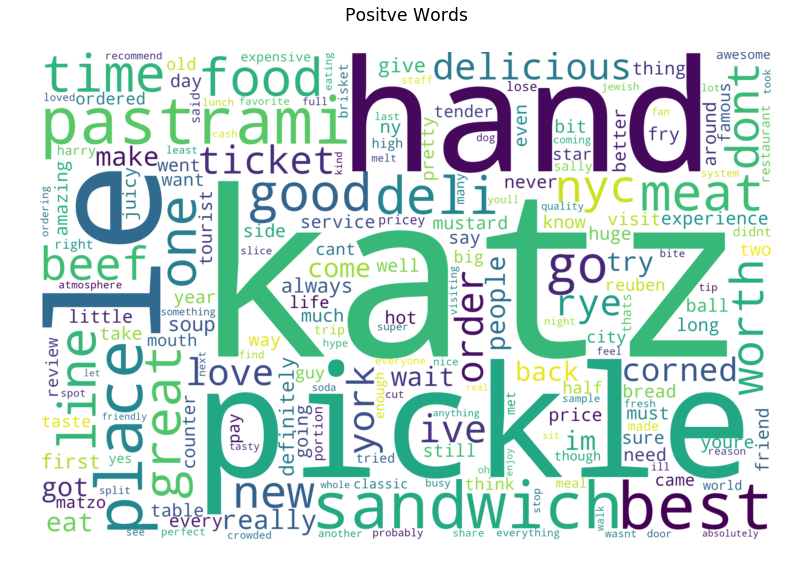

In [23]:
wordcloud_draw(pos_bows, 'white', title = "Positve Words")

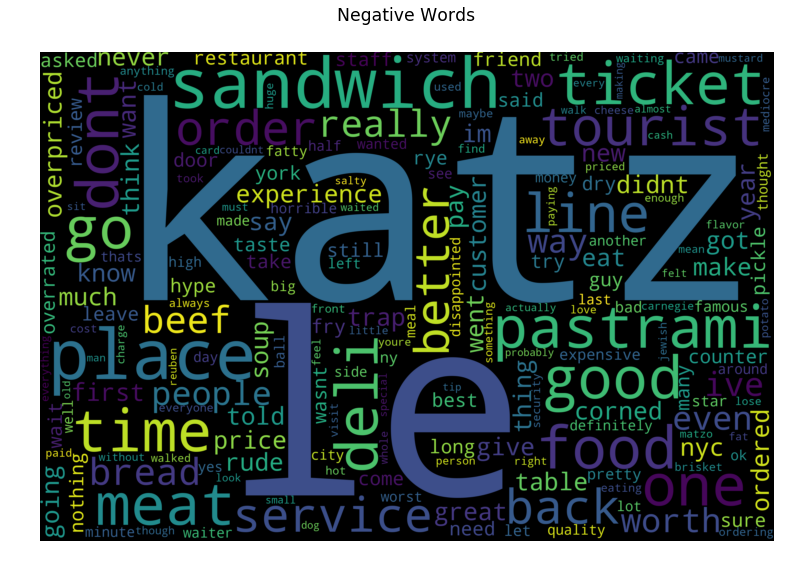

In [24]:
wordcloud_draw(neg_bows, title= "Negative Words")

## OBSERVATIONS:

    We notice some words are present in both positive and negative reviews.This is to be expected because customers could use them irrespective of the sentiments behind their statements. For example the name of the restaurant Katz can be used in a positive or negative sense. However, some words are more prominient in the negative reviews. Some of these words include:
    time, place, price, pastrami, food, sandwich,ticket, tourist, overpriced and rude. These are very likely to be complaints about the waiting time, the staff, price and the food served expecially the sandwich.

    On the other hand, words like pickle, pastrami,new and hand are more frequently used in positive reviews.  It seems many customers love these.

In [25]:
# creating a list for both positive and negetive bag of words
all_words = []
all_words.extend(pos_bows)
all_words.extend(neg_bows)

In [26]:
len(all_words)

1200

In [27]:
# Generate a frequency distritution dictionary for bag of words 
Bow_freq = nltk.FreqDist(all_words)

In [28]:
features = [i[0] for i in sorted(Bow_freq.items(), key=lambda x: x[1], reverse=True)]

In [29]:
len(features)

751

    Next we create a list that we'll call documents and append all our original positive and negative reviews in addition to the labels.labels are either positive or negative.We tokenize the document into pieces of words and find out if the words we have in features are also in each in tokenized documents. The results will be our feature set that we'll use for training and testing our algorithms.

In [30]:
document=[]
for sent in pos['review']:
    document.append( (sent.lower(),'positive') )

In [31]:
for sent in neg['review']:
    document.append((sent.lower(),'negative'))

In [32]:
def find_features(doc):
    """
    this funtion takes in a document and tokenize it. 
    Thereafter for each word in our features, we check if we have this in the tokenized tokenment.
    we put the bolean results in a dict name checked features.
    """
    docs = word_tokenize(doc)
    checked_features ={}
    for w in features:
        checked_features[w] = (w in docs)
    return checked_features

In [33]:
# applying the fuction to the document that contains all reviews in our dataset.
# The feature_set will be used to training the model.
feature_set = [(find_features(rev),category) for (rev, category) in document]

In [34]:
import random
random.shuffle(feature_set)

In [35]:
len(feature_set)

6809

In [36]:
# we divide the feature_set into training and test sets.
training_set = feature_set[:5500]
test_set = feature_set[5500:]

In [37]:
# importing various classifier algorithms
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [38]:
# we train with the algorithms and check their accuracy. 

nb_cls = nltk.NaiveBayesClassifier.train(training_set)
print("Classifier accuracy percent:",(nltk.classify.accuracy(nb_cls, test_set))*100)
nb_cls.show_most_informative_features(10)

MNB_clf = SklearnClassifier(MultinomialNB())
MNB_clf.train(training_set)
print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_clf, test_set))*100)

BNB_clf = SklearnClassifier(BernoulliNB())
BNB_clf.train(training_set)
print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BNB_clf, test_set))*100)

LogReg_clf = SklearnClassifier(LogisticRegression())
LogReg_clf.train(training_set)
print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogReg_clf, test_set))*100)

SGD_clf = SklearnClassifier(SGDClassifier())
SGD_clf.train(training_set)
print("SGDClassifier_classifier accuracy percent:", (nltk.classify.accuracy(SGD_clf, test_set))*100)

SVC_clf = SklearnClassifier(SVC())
SVC_clf.train(training_set)
print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_clf, test_set))*100)

RF_clf = SklearnClassifier(RandomForestClassifier())
RF_clf.train(training_set)
print("RandomForest accuracy percent:", (nltk.classify.accuracy(RF_clf, test_set))*100)


Classifier accuracy percent: 89.53399541634836
Most Informative Features
                mediocre = True           negati : positi =     52.4 : 1.0
              disgusting = True           negati : positi =     47.7 : 1.0
                  filthy = True           negati : positi =     36.8 : 1.0
                horrible = True           negati : positi =     31.2 : 1.0
               tasteless = True           negati : positi =     30.8 : 1.0
                   worst = True           negati : positi =     29.1 : 1.0
               overrated = True           negati : positi =     23.1 : 1.0
                   awful = True           negati : positi =     22.6 : 1.0
                   nasty = True           negati : positi =     19.8 : 1.0
                received = True           negati : positi =     19.8 : 1.0
MNB_classifier accuracy percent: 91.21466768525592
BernoulliNB_classifier accuracy percent: 88.84644766997708
LogisticRegression_classifier accuracy percent: 91.67303284950343


C:\Users\Ikeen\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier_classifier accuracy percent: 88.61726508785333
SVC_classifier accuracy percent: 84.64476699770817
RandomForest accuracy percent: 88.23529411764706


    We now create a list of fresh reviews from another restuarant listing on yelp and test them on the best performing model.

In [39]:
reviews= ["Was simply amazing. And that tea leaf salad. Definitely coming back!",
          
"""Used to be good. I have no idea how it got so bad. Everything tasted like leftovers from last week.
Shrimp were mush. Platha was a brick. No way it was made that day. Rainbow salad was 90% cabbage and noodles.
No visible papaya. Eggplant was edible. The rest was not. Too bad""",
          
"""I just really don't understand why people wait in line to eat here. 
The first time I ate here, after waiting outside for an hour to be seated, I was underwhelmed with the food and 
just generally disappointed after hearing so many rave reviews from friends. But I figured that could just have 
been an off day or that perhaps I just hadn't ordered the right dish, especially since people really seem to love this place. 
So I went back and tried it a few more times. I've tried to like this place, I really have. But the food just isn't that great. 
I tried the famed tea leaf salad...why do people love this dish so much? Is it just because it is a unique dish that you won't 
see at other places? Because aside from that I just don't see what the big deal is. I think people just feel special saying 
\"tea leaf salad\". Seriously I don't know what else would make someone say this is such a good dish. I tried many other items
there as well and it's just rather ordinary asian food. The garlic noodles, citrus chicken, and everything else I tried there 
left me totally underwhelmed and questioning why I've spent hours of my life standing around outside this place waiting to eat
this completely overrated food. The portions are small, too. I definitely would not wait in line to eat there again. 
Actually, I'm just going to say it, I wouldn't eat there again at all. I read these yelp reviews to try to understand the appeal
and I noticed that 9 out of 10 of the rave reviews appear to have been written by young women. Maybe chicks just like being able
to tell their friends \"ohhmygawd I had the tea leaf salad and it was ah-mazing\". 
Or, maybe they enjoy getting to drag their poor boyfriends here when it's their turn to pick a restaurant. 
I don't know. All I know is it's definitely not the food. This place sucks.""",
          
"""Great place, I've been here a couple times but just now posting review because I wanted to try a few more dishes before saying this place Â is DELICIOUS.
Service is great, the dishes come fast and hot. There is always a wait so do call in or get on waitlist. Must try.""",
          
"""Okay I don't get it? I love Burmese food and if try this place several times. And always seems to have them a line to get in.
The staff inspired with walkie talkies and earpieces.""",
          
"""The wait for this place is not worth it. I waited one hour and a half only to enjoy a mediocre meal. 
I'm either cursed by the hype or the food quality has went down. I'm not from the area and it's my 
first time here so I'm not sure what it could've been. I do not consider myself to have a fair share of Burmese cuisine
but I do know that they're usually a unique combination of spices and seasonings. I have my favorite Burmese 
restaurant on the east side but Burma Superstar did not compare.""",
          
"""I was driving through SF and was starving when I saw on my yelp app that there's a Burma Superstar in SF--awesome.
Â I've only ever been to the one in Oakland. Â I have to say, this just did not live up to the Oakland restaurant's 
standards. Â The waitstaff, host etc were all super nice, but the food was just not that good. 
Â The Samusa salad was off, and the sesame chicken was not crisp, gooey and meh. Â We were there really late, 
and maybe being the last seating we got the dregs of the night. Â But I was really disappointed. 
Â I think I'll stick to the one in Oakland."""]

In [40]:
def sent_log(text):
    feature = find_features(text)
    return LogReg_clf.classify(feature)

In [41]:
for rev in reviews:
    print(sent_log(rev))

positive
negative
negative
positive
positive
negative
negative


    Our Logistic Regression model correctly predicted 6 out of 7 reviews. That's near perfect! The 5th review is a sarcastic statement so it is understandable why the model couldn't predict its sentiment correctly.

## CONCLUSION:
    The sentiment analysis of customer reviews of the restaurant prove to be very effective. It is apparent that the business have to work on their staffs being more polite, reduce wait time by possibly employing more hands. They also have to look into the pricing and work on making their food expecially th sandwich better.

    Our model also affords us the convenience of predicting future reviews as positive or negative. This will save us the time of reading each review to find out what the customers feel about the services and food.
    
    We could also improve this model by predicting the type of negative or positive review a  customer gives by  categorizing the reviews with proper tags like: customer service, pricing, food, environment etc. We can then vizualize the results to compare the positivity or negativity each tag.